## Vernalis

This is the brainstorm for the Vernalis main quest. For now it's just hacking around with solutions to population models.

Introductory flavor text. Brainstorm different ways in which one species can affect the population of another (predation, parasitism, competition for a resource, etc.) Begin with predation and discuss Lotka-Volterra

$$ \begin{align}
\frac{du}{dt} &= a u - b u v \nonumber \\
\frac{dv}{dt} &= -c v + d b u v \nonumber
\end{align}$$

$u$ is amount of prey, $v$ is amount of predator, $a$ is natural prey growth rate, $b$ controls the strength of predation, $c$ is the natural dying rate of predators, and $d$ controls the predator growth as a consequence of consuming prey.

<IPython.core.display.Javascript object>


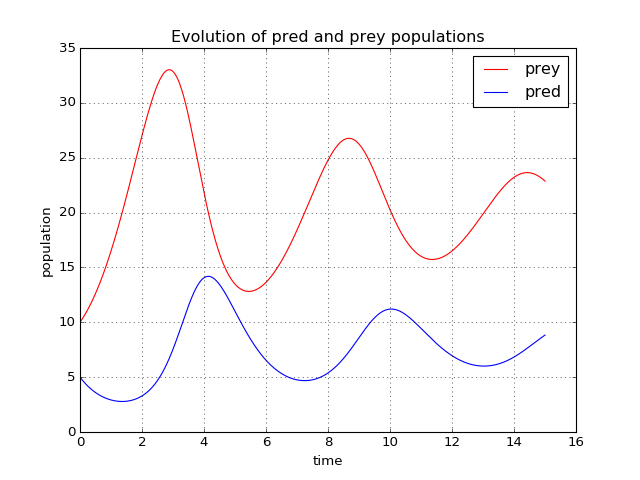

In [17]:
%matplotlib notebook
from numpy import *
import matplotlib.pyplot as plt

# Definition of parameters
a = 1.
b = 0.1
c = 1.5
d = 0.75

# def standard_vl(X, t=0):
#     """ Return the growth rate of fox and rabbit populations. """
#     return array([ a*X[0] -   b*X[0]*X[1] ,
#                   -c*X[1] + d*b*X[0]*X[1] ])


def logistic_prey(X, K, t=0):
    """ Return the growth rate of fox and rabbit populations. """
    return array([ a*X[0]*(1 - X[0]/K) -   b*X[0]*X[1] ,
                  -c*X[1] + d*b*X[0]*X[1] ])

def get_logistic_prey(K):
    
    def logistic_prey(X, t=0):
        """ Return the growth rate of fox and rabbit populations. """
        return array([ a*X[0]*(1 - X[0]/K) -   b*X[0]*X[1] ,
                      -c*X[1] + d*b*X[0]*X[1] ])
    
    return logistic_prey

dX_dt = get_logistic_prey(100)

from scipy import integrate
t = linspace(0, 15,  1000)              # time
X0 = array([10, 5])                     # initials conditions: 10 prey and 5 predators
#X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)
X, infodict = integrate.odeint(my_log, X0, t, full_output=True)

rabbits, foxes = X.T
f1 = plt.figure()
plt.plot(t, rabbits, 'r-', label='prey')
plt.plot(t, foxes  , 'b-', label='pred')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of pred and prey populations')

<IPython.core.display.Javascript object>


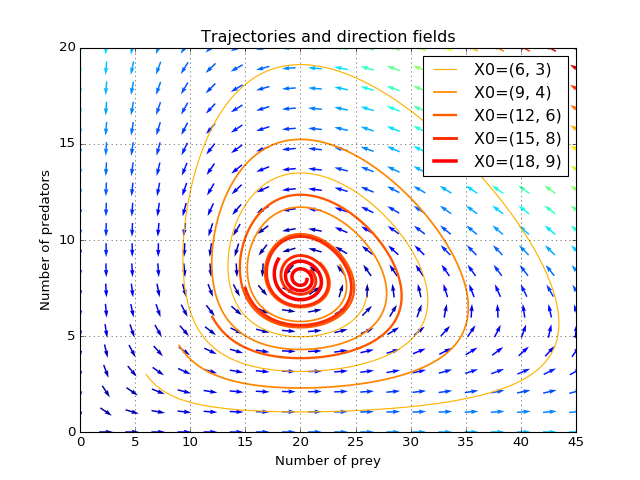

(0, 20.0)

In [18]:
values  = linspace(0.3, 0.9, 5)                          # position of X0 between X_f0 and X_f1
vcolors = plt.cm.autumn_r(linspace(0.3, 1., len(values)))  # colors for each trajectory

f2 = plt.figure()

#-------------------------------------------------------
# plot trajectories
for v, col in zip(values, vcolors):
    X0 = v * X_f1                               # starting point
    X = integrate.odeint( dX_dt, X0, t)         # we don't need infodict here
    plt.plot( X[:,0], X[:,1], lw=3.5*v, color=col, label='X0=(%.f, %.f)' % ( X0[0], X0[1]) )

#-------------------------------------------------------
# define a grid and compute direction at each point
ymax = plt.ylim(ymin=0)[1]                        # get axis limits
xmax = plt.xlim(xmin=0)[1]
nb_points   = 20

x = linspace(0, xmax, nb_points)
y = linspace(0, ymax, nb_points)

X1 , Y1  = meshgrid(x, y)                       # create a grid
DX1, DY1 = dX_dt([X1, Y1])                      # compute growth rate on the gridt
M = (hypot(DX1, DY1))                           # Norm of the growth rate
M[ M == 0] = 1.                                 # Avoid zero division errors
DX1 /= M                                        # Normalize each arrows
DY1 /= M

#-------------------------------------------------------
# Drow direction fields, using matplotlib 's quiver function
# I choose to plot normalized arrows and to use colors to give information on
# the growth speed
plt.title('Trajectories and direction fields')
Q = plt.quiver(X1, Y1, DX1, DY1, M, pivot='mid', cmap=plt.cm.jet)
plt.xlabel('Number of prey')
plt.ylabel('Number of predators')
plt.legend()
plt.grid()
plt.xlim(0, xmax)
plt.ylim(0, ymax)

First part involves understanding and generating the above plots; tasks involve filling in small pieces of the code. For example, we wrap and hand them the function that generates an array given initial conditions, then ask them to get the list and plot. Can also ask them to do some basic analysis on the data, like extracting the period of oscillations.

A couple things to think about for expanding in the next phase:
* Studying the effects of changing a, b, c, d, and the initial populations.
* Adding more species or coupling to some external quantity like the soil quality, which is adversely affected.
* Better models. Logistic prey, competition for resources, spatial locality, generalized VL or replicator
* Alternative monster choices. Parasite.

<IPython.core.display.Javascript object>


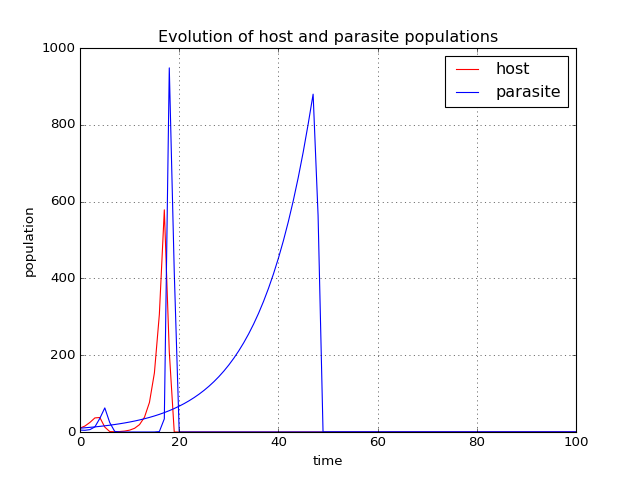

In [34]:
import numpy as np

def nicholson_bailey(h_0, p_0, k, a, c, time_steps=100):
    h_out = np.zeros(time_steps+1)
    p_out = np.zeros(time_steps+1)
    
    h_out[0] = h_0
    p_out[0] = p_0
    
    for i in range(time_steps):
        this_h = h_out[i]
        this_p = p_out[i]
        
        next_h = k*this_h*np.exp(-a*this_p)
        next_p = c*this_h*(1 - np.exp(-a*this_p))
        
        h_out[i+1] = next_h
        p_out[i+1] = next_p
        
    return h_out, p_out

rabbits, foxes = nicholson_bailey(h_0=10, p_0=5, k=2.0, a=0.05, c=2.0, time_steps=100)
t = range(101)
f1 = plt.figure()
plt.plot(t, rabbits, 'r-', label='host')
plt.plot(t, foxes  , 'b-', label='parasite')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of host and parasite populations')

Note that the parasite-host equations always give oscillations of increasing magnitude until there's a crash and both die out. We don't want to show this to students so this one should go on a grid.

In [121]:
import itertools
import numba

## Nicholson-Bailey on a grid, with logistic growth for both parasite and host.
## Setting h_max or p_max to np.inf reduces to exponential base growth case.

@numba.jit
def parasite_update(h, p, k, a, c, h_max, p_max):
    h_out = np.zeros(h.shape)
    p_out = np.zeros(p.shape)
    
    for (i, j), this_h in np.ndenumerate(h):
        this_p = p[i, j]
        next_h = k*this_h*(1-this_h/h_max)*np.exp(-a*this_p)
        next_p = c*this_h*(1-this_p/p_max)*(1 - np.exp(-a*this_p))
        
        h_out[i, j] = next_h
        p_out[i, j] = next_p
        
    return h_out, p_out

def get_neighbors(x, y, x_max, y_max):
    possibilities = list(itertools.product((x-1, x, x+1), (y-1, y, y+1)))
    my_filter = lambda (i, j): 0 <= i < x_max and 0 <= j < y_max and (i != x or j!= y)
    
    return filter(my_filter, possibilities)

def diffusion_update(h, p, dh, dp, neighbor_dict):
    h_out = np.zeros(h.shape)
    p_out = np.zeros(p.shape)
    
    for (i, j), this_h in np.ndenumerate(h):
        my_neighbors = neighbor_dict[(i, j)]        
        this_p = p[(i, j)]
        
        h_neighbor_sum = p_neighbor_sum = 0.0
        for neighbor in my_neighbors:
            total_h_leaving_neighbor = dh*h[neighbor]
            total_p_leaving_neighbor = dp*p[neighbor]
            number_of_cells = len(neighbor_dict[neighbor])
            
            h_amount_flowing_in = total_h_leaving_neighbor/number_of_cells
            p_amount_flowing_in = total_p_leaving_neighbor/number_of_cells
            
            h_neighbor_sum += h_amount_flowing_in
            p_neighbor_sum += p_amount_flowing_in
        
        h_out[(i, j)] = (1 - dh)*this_h + h_neighbor_sum
        p_out[(i, j)] = (1 - dp)*this_p + p_neighbor_sum
        
    return h_out, p_out

def nicholson_bailey_grid(h_0, p_0, k, a, c, dh, dp, h_max, p_max, time_steps=100):
    x_max, y_max = h_0.shape
    
    h_out = np.zeros((time_steps+1, x_max, y_max))
    p_out = np.zeros((time_steps+1, x_max, y_max))

    neighbor_dict = {}
    ## Store neighbors for diffusion calculation
    for (i,j), value in np.ndenumerate(h_0):
        neighbor_dict[(i, j)] = get_neighbors(i, j, x_max, y_max)
    
    h_out[0] = h_0
    p_out[0] = p_0
    
    for i in range(time_steps):
        this_h = h_out[i]
        this_p = p_out[i]
        
        next_h, next_p = diffusion_update(this_h, this_p, dh, dp, neighbor_dict)
        next_h, next_p = parasite_update(next_h, next_p, k, a, c, h_max, p_max)
        
        h_out[i+1] = next_h
        p_out[i+1] = next_p
        
    return h_out, p_out

h0 = 10*np.ones((100, 100))
p0 = np.zeros((100, 100))
p0[50, 50]=2
p0[0, 30] = 1
p0[90, 72] = 3

h, p = nicholson_bailey_grid(h_0=h0, p_0=p0, k=1.1, a=0.05, c=1.0, dh=0.1, dp=0.1, h_max=100, p_max = 100, time_steps=100)
# t = range(101)
# f1 = plt.figure()
# plt.plot(t, rabbits, 'r-', label='host')
# plt.plot(t, foxes  , 'b-', label='parasite')
# plt.grid()
# plt.legend(loc='best')
# plt.xlabel('time')
# plt.ylabel('population')
# plt.title('Evolution of host and parasite populations')

<IPython.core.display.Javascript object>


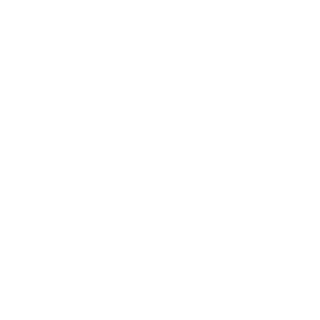

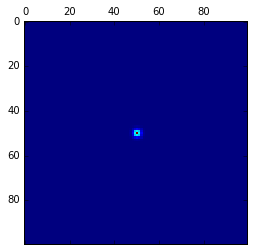

In [120]:
%matplotlib notebook
#sample = [h[t, 20, 20] for t in range(101)]
plt.matshow(p[15])

In [88]:
from IPython.html.widgets import *
%matplotlib inline

C:\Users\cferko\Anaconda2\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [118]:
%matplotlib inline

def my_plot(t):
    plt.imshow(p[t]) ## TODO: This is way too slow, figure out how to use plt.set_data to blit

interact(my_plot, t=(1, 100, 1))